# Activations recorded

## Prep Functions- show images

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from time import time
from torch.utils.data import Dataset

In [2]:
def plot_accuracy_loss(training_results):
    plt.subplot(2, 1, 1)
    plt.plot(training_results['training_loss'], 'r')
    plt.ylabel('loss')
    plt.title('training loss iterations')
    plt.subplot(2, 1, 2)
    plt.plot(training_results['validation_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.show()

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))
    plt.show()

def show_dataComp(data_sample,y):
    plt.subplot(1,2,1)
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(data_sample[1].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(y))

    plt.show()

## Img Pairing and Data Prep

1) traindataComp-trainloader: consecutive data pairs from the training set <br>
2) valdataComp-valloader: consecutive data pairs from the test set <br>
3) testdata- testloader: all data pairs from test set- keeps track of the pair <br>

In [3]:
def indlist(target):
    indlist = [[],[],[],[],[]]
    
    for i in range(len(target)):
        if target[i] < 5:
            indlist[target[i]].append(i)
    return indlist

def subData(dataSet):
    #gets all the indices of the data obsv with same y from the dataset that is passed in only for 0-4
    indices = indlist(dataSet.targets)
    # a list of datasets where each dataset has the data for the same number
    subsets = []
    [subsets.append(torch.utils.data.Subset(dataSet, i)) for i in indices]
    return subsets
    

In [4]:
def comparisonDataConsecutive(dataSet):
    subsets = subData(dataSet)
    # a list of the size of the possible pairs
    comp = []
    for indi in range(len(subsets) - 1):
        comp.append(int(min(len(subsets[indi]), len(subsets[indi + 1]))))
    tot1 = sum(comp)
    # img pair data stored
    x = torch.zeros([tot1, 2, 28, 28], dtype=torch.float32)
    # greater than or less than label stored
    y = torch.zeros([tot1,1])
    # 1 for first pic greater, 0 for first pic less
    k = 0
    # does the actual pairing
    for i in range(len(subsets) - 1):
        for j in range(int(comp[i] / 2)):
            x[k][0] = subsets[i][j][0]
            x[k][1] = subsets[i + 1][j][0]
            y[k][0] = 0
            k += 1
        for j in range(int(comp[i] / 2), comp[i]):
            x[k][1] = subsets[i][j][0]
            x[k][0] = subsets[i + 1][j][0]
            y[k][0] = 1
            k += 1
    return x,y

In [5]:
def comparisonDataNonconsecutive(dataSet):
    subsets = subData(dataSet)
    # a dictionary of pairs and the size of the pairings
    comp = {}
    
    for i in range(len(subsets) - 2):
        for j in range(i + 2, len(subsets), 1):
            comp[(i, j)] = int(min(len(subsets[i]), len(subsets[j])))
    tot = sum(comp.values())
    # greater than or less than label stored
    x = torch.zeros([tot, 2, 28, 28], dtype=torch.float32)
    # 1 for first pic greater, 0 for first pic less
    y = torch.zeros([tot, 1])
    k = 0
    #the pairing
    for key, values in comp.items():
        for value in range(int(values / 2)):
            x[k][0] = subsets[key[0]][value][0]
            x[k][1] = subsets[key[1]][value][0]
            y[k][0] = 0
            k += 1
        for value in range(int(values / 2), values):
            x[k][0] = subsets[key[1]][value][0]
            x[k][1] = subsets[key[0]][value][0]
            y[k][0] = 1
            k += 1
    return x,y


In [6]:
def comparisonAll(dataSet):
    subsets = subData(dataSet)
    # a dictionary of pairs(tuple) and the size of the pairings
    comp = {}
    for i in range(len(subsets) - 1):
        for j in range(i + 1, len(subsets), 1):
            comp[(i, j)] = int(min(len(subsets[i]), len(subsets[j])))
    #print(len(comp.keys()))
    #print(comp.keys())
    tot = sum(comp.values())
    # greater than or less than label stored
    x = torch.zeros([tot, 2, 28, 28], dtype=torch.float32)
    # 1 for first pic greater, 0 for first pic less
    y = torch.zeros([tot, 1])
    z = list()
    k = 0
    # the pairining
    for key, values in comp.items():
        for value in range(int(values / 2)):
            x[k][0] = subsets[key[0]][value][0]
            x[k][1] = subsets[key[1]][value][0]
            y[k][0] = 0
            z.append(key)
            k += 1
        for value in range(int(values / 2), values):
            x[k][0] = subsets[key[1]][value][0]
            x[k][1] = subsets[key[0]][value][0]
            y[k][0] = 1
            a = key[0]
            b = key[1]
            c = (b,a)
            z.append(c)
            k += 1
    return x,y,z

In [7]:
class Trainsetcomp(Dataset):
    def __init__(self, x, y):
        self.len = (x.shape[0])
        self.x = x
        self.y = y 

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return self.len

In [8]:
class TrainsetcompwithA(Dataset):
    def __init__(self, x, y, z):
        self.len = (x.shape[0])
        self.x = x
        self.y = y 
        #the pair
        self.z = z

    def __getitem__(self, index):
        return (self.x[index], self.y[index], self.z[index])

    def __len__(self):
        return self.len

In [9]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),])

trainset = dsets.MNIST(root='./../data',
                            train=True,
                            download=True,
                            transform=transform)
valset = dsets.MNIST(root='./../data',
                            train=False,
                            download=True,
                            transform=transform)

In [10]:
x, y = comparisonDataConsecutive(trainset)
traindataComp = Trainsetcomp(x,y)
x,y = comparisonDataConsecutive(valset)
valdataComp = Trainsetcomp(x,y)

In [11]:
trainloader = torch.utils.data.DataLoader(traindataComp,
                                          batch_size=64,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(valdataComp,
                                          batch_size=64,
                                          shuffle=True)
x,y,z = comparisonAll(valset)
testdata = TrainsetcompwithA(x,y,z)
testloader = torch.utils.data.DataLoader(testdata,
                                          batch_size=64,
                                          shuffle=F)
# in the test loader: z is a list of size 2 of two [64] shape tensors. - it turned the tuple into a list of tensors

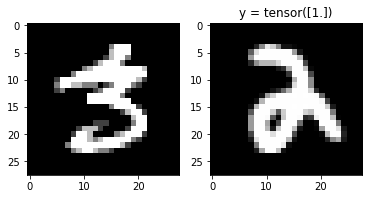

tensor(3) tensor(2)


In [12]:
## showing what the z in the test loader is- ignore
i = 1
j = 0
for x,y,z in testloader:
    j+=1
    p = x[i,:,:,:]
    show_dataComp(p,y[i,:])
    #print(z)
    print(z[0][i],z[1][i])
    if j >= 1:
        break

## Model

In [13]:
ind = 2 * 28 * 28
hiddendim = [400,200,64]
outd = 1
# 0 if first image is less than and 1 if frist image is greater than

In [14]:
class ModelFull(nn.Module):
    def __init__(self, ind,h1d,h2d,h3d,outd):
        super(ModelFull, self).__init__()
        self.lin1 = nn.Linear(ind, h1d)
        self.lin2 = nn.Linear(h1d, h2d)
        self.lin3 = nn.Linear(h2d, h3d)
        self.lin4 = nn.Linear(h3d, outd)
        self.activations1 = []
        self.activations2 = []
        self.activations3 = []
        self.pairs = []

    def forward(self, x, recActivations = False):
        if recActivations:
            x1 = torch.relu(self.lin1(x))
            self.activations1.append(x1)
            x2 = torch.relu(self.lin2(x1))
            self.activations2.append(x2)
            x3 = torch.relu(self.lin3(x2))
            self.activations3.append(x3)
            x4 = torch.sigmoid(self.lin4(x3))
            return x4
        else:
            x1 = torch.relu(self.lin1(x))
            x2 = torch.relu(self.lin2(x1))
            x3 = torch.relu(self.lin3(x2))
            x4 = torch.sigmoid(self.lin4(x3))
            return x4
        
    def setPair(self, pair):
        self.pairs.append(pair)

In [15]:
def train(model, criterion, optimizer, epochs = 30):
    lossList = []
    #time0 = time()
    for i in range(epochs):
        runningLoss = 0
        for x, y in trainloader:
            optimizer.zero_grad()
            yhat = model(x.view(-1, 2 * 28 *28))
            #print(yhat.shape)
            #print(y.shape)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            runningLoss += loss.item()
        print('epoch ', i, ' loss: ', str(runningLoss / len(traindataComp)))
        lossList.append(runningLoss / len(traindataComp))
    return lossList

In [16]:
model = ModelFull(ind,hiddendim[0],hiddendim[1],hiddendim[2], outd)

In [17]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03)
results = train(model,criterion,optimizer,25)

epoch  0  loss:  0.00874180811834136
epoch  1  loss:  0.00392397432464748
epoch  2  loss:  0.0020903649300904417
epoch  3  loss:  0.0014716555411239912
epoch  4  loss:  0.0012208264677241708
epoch  5  loss:  0.0010464254113545888
epoch  6  loss:  0.0008811472510547484
epoch  7  loss:  0.0007933595927612223
epoch  8  loss:  0.0006824488923198337
epoch  9  loss:  0.0005925769752976667
epoch  10  loss:  0.0005019039470126433
epoch  11  loss:  0.0004575037771946061
epoch  12  loss:  0.0004318490699398756
epoch  13  loss:  0.0005400195090518655
epoch  14  loss:  0.00040090806336376086
epoch  15  loss:  0.00023956845611349987
epoch  16  loss:  0.000325736176519547
epoch  17  loss:  0.0002119378332545719
epoch  18  loss:  0.00013057862999893365
epoch  19  loss:  0.00010905398680497535
epoch  20  loss:  6.933324124951312e-05
epoch  21  loss:  4.56172146594784e-05
epoch  22  loss:  3.344713533505702e-05
epoch  23  loss:  2.145995223445589e-05
epoch  24  loss:  1.621025167045092e-05


In [18]:
## consecutive test set
totcount = 0
correctcount = 0
for x,y in valloader:
    x = x.view(-1, 2 * 28 *28)
    with torch.no_grad():
        yhat = model(x)
    ones = torch.ones(yhat.shape)
    yhat = torch.where(yhat>.5, ones, yhat)
    z = torch.zeros(yhat.shape)
    yhat = torch.where(yhat<0.5, z, yhat)
    wrongC = 0
    for i in range(len(y)):
        #print(i)
        if yhat[i][0] == y[i][0]:
            correctcount+=1
            #p = torch.reshape(x[i], (2,28,28))
            #show_dataComp(p, y[i])
            
        else:
            #if wrongC < 2:
                #p = torch.reshape(x[i], (2,28,28))
                #show_dataComp(p, yhat[i])
            wrongC += 1
        totcount+=1
print(correctcount)
print(totcount)
print('val set accuracy: ', correctcount/totcount)

3945
4004
val set accuracy:  0.9852647352647352


In [19]:
## test data set where activations are recorded
totcount = 0
correctcount = 0
for x,y,z in testloader:
    x = x.view(-1, 2 * 28 *28)
    with torch.no_grad():
        yhat = model(x,True)
    model.setPair(z)
    ones = torch.ones(yhat.shape)
    yhat = torch.where(yhat>.5, ones, yhat)
    z = torch.zeros(yhat.shape)
    yhat = torch.where(yhat<0.5, z, yhat)
    wrongC = 0
    for i in range(len(y)):
        #print(i)
        if yhat[i][0] == y[i][0]:
            correctcount+=1
            #p = torch.reshape(x[i], (2,28,28))
            #show_dataComp(p, y[i])
            
        else:
            #if wrongC < 2:
                #p = torch.reshape(x[i], (2,28,28))
                #show_dataComp(p, yhat[i])
            wrongC += 1
        totcount+=1
print(correctcount)
print(totcount)
print('test set accuracy: ', correctcount/totcount)

9428
9918
test set accuracy:  0.9505948779995967


In [20]:
len(testdata)
print(len(testloader))
print(model.activations2[0].shape)
print(len(model.pairs))
print(model.pairs[0][1].shape)
print(model.activations2[0])
print(model.pairs[1])

155
torch.Size([64, 200])
155
torch.Size([64])
tensor([[5.3550e-01, 3.0850e+00, 3.6658e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.4091e-01, 1.7117e+00, 4.3634e-01,  ..., 8.1388e-02, 2.0882e-01,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.7371e+00,  ..., 1.2473e-01, 0.0000e+00,
         0.0000e+00],
        ...,
        [3.2501e-01, 0.0000e+00, 2.5736e-01,  ..., 0.0000e+00, 1.5732e-03,
         0.0000e+00],
        [0.0000e+00, 3.0326e-01, 8.1465e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 1.9550e+00, 1.9952e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])
[tensor([0, 2, 1, 1, 1, 4, 2, 0, 1, 2, 3, 0, 0, 4, 1, 2, 2, 0, 2, 2, 0, 0, 2, 4,
        1, 4, 0, 4, 0, 0, 3, 3, 0, 3, 1, 1, 2, 0, 1, 2, 2, 1, 2, 4, 3, 1, 1, 4,
        1, 2, 0, 3, 0, 1, 2, 1, 4, 1, 2, 3, 2, 4, 3, 0]), tensor([2, 1, 0, 0, 2, 3, 1, 4, 4, 1, 2, 2, 3, 0, 2, 1, 3, 4, 3, 1, 4, 2, 0, 3,
        4, 2, 3, 1, 1, 2, 2, 1, 3, 0, 2, 4, 4, 4, 3, 0, 4,

## RSA preprocess

In [22]:
# creates a dictionary of keys- the pair and values- the activations
def activationsDirF(mpairs, mactivations):
    activationsDict = {}
    for pair,activ in zip(mpairs, mactivations):
        for i in range(len(pair[0])):
            p1= pair[0][i].item()
            p2 = pair[1][i].item()
            key1 = (p1,p2)
            val = activ[i,:].numpy()
            if key1 in activationsDict:
                cur = activationsDict[key1]
                cur.append(val)
            else:
                activationsDict[key1]= []
                cur = activationsDict[key1]
                cur.append(val)
    for key in activationsDict.keys():
        rep = np.array(activationsDict[key])
        activationsDict[key] = rep
    return activationsDict

activationsDict1 = activationsDirF(model.pairs,model.activations1)
activationsDict2 = activationsDirF(model.pairs,model.activations2)
activationsDict3 = activationsDirF(model.pairs,model.activations3)

#check that all samples are included    
tota = 0
for key in activationsDict1.keys():
    #print(key)
    tota +=len(activationsDict1[key])
print(len(testdata))
print(tota)

9918
9918


In [25]:
# creates a dictionary of keys- the pair and values- the activations

def mkAvgDict(activationsDict):
    avgDict = {}
    for key in activationsDict:
        a = np.mean(activationsDict[key], axis=0)
        avgDict[key] = a
    return avgDict

avgDict1 = mkAvgDict(activationsDict1)
avgDict2 = mkAvgDict(activationsDict2)
avgDict3 = mkAvgDict(activationsDict3)
print (len(avgDict1.keys()))

20


In [83]:

# takes keys to sort by and returns a matrix in that order 
def sortbykey(sortedKeys, avgDict):
    size1 = avgDict[(0,1)].shape[0]
    sortedMatrix = np.empty([20,size1])
    for i in range(20):
        key = sortedKeys[i]
        sortedMatrix[i] = avgDict[key]
    return sortedMatrix

def mkUnitbyRow(matrix):
    unitMatrix = np.empty(list(matrix.shape))
    for i in range(20):
        unitMatrix[i] =  matrix[i]/np.linalg.norm(matrix[i])
    return unitMatrix




In [84]:
sortedKeys1 = sorted(avgDict1)
#print(sortedKeys1)
sortbypair = [(0,1), (1,0), (0, 2), (2, 0), (0, 3), (3, 0), (0, 4), (4, 0), (1, 2), (2, 1), (1, 3), (3, 1), 
              (1, 4), (4, 1), (2, 3), (3, 2), (2, 4), (4, 2), (3, 4), (4, 3)]
print(len(sortbypair))
lessGreater = [(0,1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4), (1,0), (2, 0), (3, 0), 
               (4, 0), (2, 1), (3, 1), (4, 1), (3, 2), (4, 2), (4, 3)]
print(len(lessGreater))
sortl = [sortedKeys1,sortbypair, lessGreater]
#print(sortl[2])

20
20


## RSA

- calc similarity measures (380 each)
- see if the similarity measures are statistically significant
- where the structure is

### Calculating the similarity- cosine similarity/pearson correlation

- i dont think pearson is necessary because there shouldnt be shifts in data 

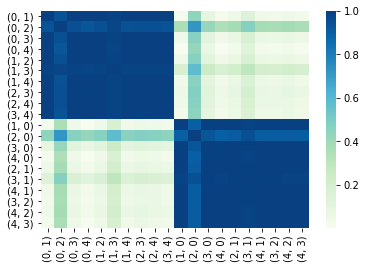

In [85]:
## similarity matrix of activation at the third hidden layer orders by less than and greater than
lgActiv3 = sortbykey(lessGreater,avgDict3)
lgActiv3 = mkUnitbyRow(lgActiv3)
simlgActiv3 = np.matmul(lgActiv3,np.transpose(lgActiv3))
hm = sns.heatmap(simlgActiv3, xticklabels=lessGreater, yticklabels=lessGreater, cmap="GnBu")

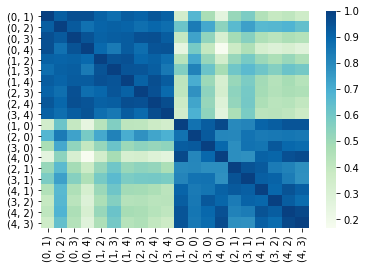

In [86]:
lgActiv2 = sortbykey(lessGreater, avgDict2)
lgActiv2 = mkUnitbyRow(lgActiv2)
simlgActiv2 = np.matmul(lgActiv2,np.transpose(lgActiv2))
hm = sns.heatmap(simlgActiv2, xticklabels=lessGreater, yticklabels=lessGreater, cmap="GnBu")

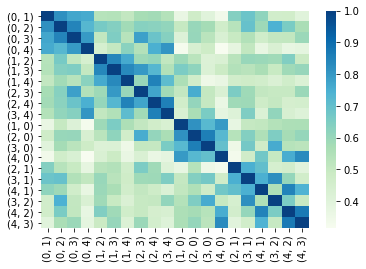

In [87]:
# activations of layer 1
lgActiv1 = sortbykey(lessGreater, avgDict1)
lgActiv1 = mkUnitbyRow(lgActiv1)
simlgActiv1= np.matmul(lgActiv1,np.transpose(lgActiv1))
hm = sns.heatmap(simlgActiv1, xticklabels=lessGreater, yticklabels=lessGreater, cmap="GnBu")

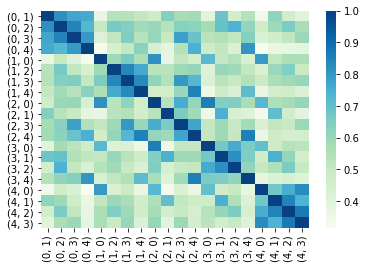

In [92]:
# activations of layer 1
s1Activ1 = sortbykey(sortedKeys1, avgDict1)
s1Activ1 = mkUnitbyRow(s1Activ1)
simActiv1= np.matmul(s1Activ1,np.transpose(s1Activ1))
hm = sns.heatmap(simActiv1, xticklabels=sortedKeys1, yticklabels=sortedKeys1, cmap="GnBu")

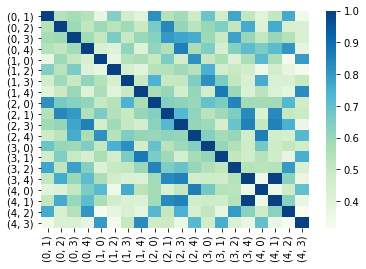

In [96]:
# activations of layer 1 by distance
distkeys = [(0,1),(1,2),(2,3),(3,4),(1,0),(2,1),(3,2),(4,3),(0,2),(1,3),(2,4),(2,0),(3,1),(4,2),(0,3),(1,4),
            (3,0),(1,4),(0,4),(4,0)]
s2Activ1 = sortbykey(distkeys, avgDict1)
s2Activ1 = mkUnitbyRow(s2Activ1)
sim2Activ1= np.matmul(s2Activ1,np.transpose(s2Activ1))
hm = sns.heatmap(sim2Activ1, xticklabels=sortedKeys1, yticklabels=sortedKeys1, cmap="GnBu")

### What if we can try to cluster the activations at each layer and see what stimuli cluster and how that differs <br>
    Wait is clustering necessary- try plotting similarity first